---
layout: post
author: phamdinhkhanh
title: Bài 56 - Knowledge Distillation học chuyển giao tri thức
---

# 1. Khái niệm về distillation

Knownledge distillation được giới thiệu bởi [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) vào năm 2015 là một trong những phương pháp của transfer learning và model compression giúp cải thiện performance của model nhỏ hơn.

Thuật toán lấy ý tưởng từ quá trình học tập ở người. Quá trình học ở trường lớp là việc kiến thức được truyền thụ từ những giảng viên có hiểu biết sâu về một lĩnh vực tới người học cần học. Ý tưởng của knownledge distillation là sử dụng hiểu biết từ model lớn có hiểu biết tốt hơn (gọi là teacher) để chuyển giao sang model nhỏ hơn (gọi là student) để nhằm cải thiện model nhỏ hơn.

Áp dụng knownledge distillation có thể tạo ra những mô hình nhỏ có độ chính xác cao hơn và từ đó triển khai được trên các thiết bị cấu hình yếu.



# 2. Quá trình distillation


Quá trình distillation sẽ bao gồm các bước:

* **Huấn luyện teacher network**: Teacher network được huấn luyện trên một tập dữ liệu đã được labeled. Bộ dữ liệu này thường có kích thước vừa đủ để teacher network học được tổng quát các trường hợp. Sau khi teacher đã đủ tốt (giả sử  đạt 95% accuracy), chúng ta sử dụng teacher để huấn luyện student. Cụ thể cách huấn luyện student sẽ như thế nào ? Mình sẽ giải thích ở bên dưới.

* **Huấn luyện student network**: Quá trình này sẽ sử dụng gợi ý từ teacher để cải thiện student. Nếu huấn luyện theo phương pháp thông thường thì student network sẽ áp dụng hàm loss function dạng cross-entropy dạng như sau:

$$CE(\mathbf{q}, \mathbf{p}) \triangleq \mathbf{H}(\mathbf{q}, \mathbf{p}) = -\sum_{i=1}^{C}q_i\log({p_i})$$

Ở đây $C$ là số lượng classes.

Cross-entropy giúp đo lường sự tương quan giữa phân phối xác suất dự báo $\mathbf{p}$ và ground-truth $\mathbf{q}$ ($\mathbf{q}$ là một one-hot véc tơ có giá trị 1 tại index trùng với ground-truth). Mục tiêu tối thiểu hoá loss function cũng chính là làm cho phân phối xác suất dự báo và ground-truth giống nhau nhất.

Để củng cố dự báo của student, trong hàm loss function teacher sẽ được sử dụng để thay thế cho ground-truth. Tức là chúng ta sẽ huấn luyện để phân phối xác suất dự báo của student gần với teacher nhất. Điều này cũng gần giống như khi bạn được giáo viên cung cấp đáp án cho một bài thi trắc nghiệm, bạn sẽ càng giỏi nếu đáp án mà bạn làm sát với đáp án mà giáo viên cung cấp nhất.

Như vậy `distillation` loss tại quan sát $\mathbf{x}_i$ sẽ có dạng:

$$\mathcal{L}_{\text{dl}}(\mathbf{x}_i; \mathbf{W}) = \mathbf{H}(\mathbf{q}_{it}, \mathbf{q}_{is})$$

Với $\mathbf{q}_{it}$ là phân phối xác suất của dự báo từ teacher và $\mathbf{q}_{is}$ là phân phối xác suất dự báo từ student tại quan sát thứ $i$.

Cách biến đổi này còn giúp cho việc học không bị _cứng nhắc_ vì giúp nhận thức được sự khác biệt giữa các bức ảnh thuộc về cùng một nhãn. Cụ thể, cùng là nhãn `dog` nhưng một số bức ảnh có thể giống `dog` hơn hoặc ít giống `dog` hơn (VD: những loài chó có lông xù giống mèo). Thay vì đều được gán nhãn là 1 thì bức giống hơn sẽ có xác suất cao hơn so với ảnh ít giống hơn.

![](https://www.petspyjamas.com/uploads/2013/07/can-cats-and-dogs-be-friends-6.jpg)

**Hình 1**: Dog like a cat.


Ngoài ra ở một số quan sát thì kết quả dự báo từ teacher khá là thô cứng. Xác suất dự báo của class trùng với grounth-truth rất gần 1 và các xác suất còn lại tiệm cận 0. Điều đó dẫn tới việc áp dụng dự báo từ teacher không khác nhiều so với việc chúng ta áp dụng ngay phân phối ground-truth vào loss function. Chính vì thế, `Geoffrey Hinton` đã đề xuất một phương pháp mới nhằm tạo ra một phân phối xác suất `soft logit` mềm hơn. Đó là một phép biến đổi giúp cho các xác suất lớn không quá gần 1 và các xác suất nhỏ không tiệm cận 0. Chẳng hạn ta có một phân phối xác suất $[0.99, 0, 0, 0.01]$ thì thông qua phương pháp này có thể chuyển thành phân phối xác suất mới $[0.65, 0.1 , 0.1, 0.15]$ chẳng hạn. Việc này đã được chứng minh trên thực nghiệm là giúp cho quá trình học tạo ra mô hình tốt hơn.

Phương pháp biến đổi xác suất được gọi là `temperature scale`.


## 2.1. Temperature scale

Đây là một phương pháp calibration score làm cho softmax score trở nên **smoothing** hơn. Cụ thể, giả sử ta có một phân phối xác suất dựa trên hàm softmax của véc tơ input $\mathbf{x} = (x_1, x_2, \dots , x_C)$ như sau:

$$e_i = \frac{\exp(x_i)}{\sum_{k=1}^{C} \exp(x_k)}$$

Trong đó $C \in \mathbb{N}$ là số lượng classes output.
Khi áp dụng calibration xác suất theo hệ số temperature scale $T$ ta sẽ thu được xác suất mới là:

$$e_i' = \frac{\exp(x_i/T)}{\sum_{k=1}^{C} \exp(x_k/T)}$$

với $\forall i=\overline{1,C}$

Xác suất mới $e_i'$ còn được gọi là `softmax temperature` được đề suất bởi Geoffrey Hinton vào 2015. Trong công thức của $e_i'$, $T$ thường được lựa chọn là một giá trị từ 1 tới 5. Trường hợp $T=1$ thì $\mathbf{e}=\mathbf{e}'$ và đây là giá trị softmax thông thường.

Khi $T$ càng lớn thì giá trị của phân phối xác suất `softmax temperature` $\mathbf{e}'$ sẽ càng smoothing hơn so với $\mathbf{e}$. Thật vậy, để chứng thực điều này, bên dưới chúng ta cùng khởi tạo một véc tơ logit score $\mathbf{x}$ ngẫu nhiên. Visualize để so sánh phân phối xác suất trước và sau khi calibration với $T=2$.


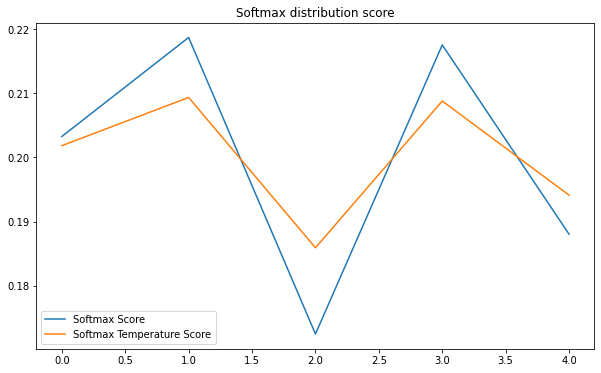

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random probability distribution
x = np.random.rand(5)
x = x/np.sum(x)

def softmax(x):
  score = np.exp(x)/np.sum(np.exp(x))
  return score

def softmax_scale(x, temp):
  x = [i/temp for i in x]
  score_scale = softmax(x)
  return score_scale

score_1 = softmax(x)
score_2 = softmax_scale(x, 2)

def _plot_line(score1, score2):
  assert len(score1) == len(score2)
  classes = np.arange(len(score1))
  plt.figure(figsize=(10, 6))
  plt.plot(classes, score1, label="Softmax Score")
  plt.plot(classes, score2, label = "Softmax Temperature Score")
  # plt.ylim([0, 1])
  plt.legend()
  plt.title("Softmax distribution score")
  plt.show()

_plot_line(score_1, score_2)

Ta nhận thấy đường màu xanh lá cây của `Softmax Temperature` khi áp dụng calibration smoothing hơn so với đường màu xanh dương của `Softmax Score`. Thứ tự về độ lớn của xác suất của các phần tử không thay đổi ở cả hai distribution nên sau khi calibration không ảnh hưởng tới dự báo nhãn.

Tại sao áp dụng calibration lại giúp tạo ra một chuỗi smoothing hơn? Nguyên nhân chính đó là hệ số temperature đã làm giảm **phương sai** của phân phối xác suất. Thật vậy, ta sẽ chứng minh rằng phương sai của phân phối xác suất $\mathbf{e}$ sẽ lớn hơn $\mathbf{e}'$. 

Trước tiên ta dựa trên một đẳng thức quan trọng về phương sai:

$$\begin{eqnarray}
\text{Var}{(\mathbf{e})} & = & \mathbf{E}(\mathbf{e}^2)-[\mathbf{E}(\bar{\mathbf{e}})]^2 \\
& = & \mathbf{E}(\mathbf{e}^2)-\frac{1}{C^2}
\end{eqnarray}$$

Dòng thứ 2 là vì $\mathbf{E}(\bar{\mathbf{e}}) = \frac{1}{C}$ với $C$ là số lượng classes.

Như vậy để chứng minh phương sai của $\mathbf{e}$ lớn hơn $\mathbf{e}'$ ta qui về chứng minh:

$$\mathbf{E}(\mathbf{e}^2) \geq \mathbf{E}(\mathbf{e'}^2)$$

Đặt:

$$\begin{eqnarray}f(\mathbf{x}, T) & \triangleq & C~\mathbf{E}(\mathbf{e}^2)\\
& = & \sum_{i=1}^{C} [\frac{\exp(x_i/T)}{\sum_{i=1}^{C} \exp(x_i/T)}]^2 \\
& = & \sum_{i=1}^{C}[\sigma(x_i/T)]^2
\end{eqnarray}$$

Trong đó $\mathbf{x}$ là một véc tơ phân phối xác suất của $C$ classes và $T$ là hệ số temperature, $T \geq 1$.

Để đơn giản hoá, ta sử dụng $\sigma(x_i)$ là ký hiệu của hàm sigmoid thay cho công thức $\frac{\exp(x_i)}{\sum_{i=1}^{C} \exp(x_i)}$.

Một tính chất khá quan trọng của đạo hàm sigmoid:

$$\frac{\delta ~ \sigma(x)}{\delta ~ x} = \sigma(x)(1-\sigma(x))$$

Như vậy:


$$\begin{eqnarray}\frac{\delta f(\mathbf{x}, T)}{\delta \space T} & = & \sum_{i=1}^{C}\frac{\delta ~ \sigma(x_i/T)^2}{\delta \space T} \\
& = & \sum_{i=1}^{C}\frac{\delta ~ \sigma(x_i/T)^2}{\delta ~ \sigma(x_i/T)}~\frac{\delta ~ \sigma(x_i/T)}{\delta \space x_i/T}~\frac{{\delta \space x_i/T}}{\delta ~ T} \\
& = & \sum_{i=1}^{C}2~\sigma(x_i/T)~\sigma(x_i/T)~(1-\sigma(x_i/T))~\frac{{\delta \space x_i/T}}{\delta ~ T} \\
& = & \sum_{i=1}^{C}2~\sigma(x_i/T)^2~(1-\sigma(x_i/T))~\frac{{-x_i}}{T^2}
\end{eqnarray}$$

Do $\sigma(x_i/T) \in (0, 1)$ và $x_i \geq 0$ nên 

$$2~\sigma(x_i/T)^2~(1-\sigma(x_i/T))~\frac{{-x_i}}{T^2} \leq 0, ~ \forall x_i, i=\overline{1,C}$$

Tức là $$\frac{\delta f(\mathbf{x}, T)}{\delta \space T} \leq 0$$

Suy là $f(\mathbf{x}, T)$ là một hàm nghịch biến. Do đó $f(\mathbf{x}, T) \leq f(\mathbf{x}, 1)$, suy ra $\mathbf{E}(\mathbf{e}^2) \geq \mathbf{E}(\mathbf{e'}^2)$ kéo theo $\text{Var}(\mathbf{e}) \geq \text{Var}{(\mathbf{e}')}$.

Như vậy ta đã chứng minh được rằng việc áp dụng calibration đã làm cho phương sai của phân phối xác suất nhỏ hơn chính vì thế ta có cảm giác rằng phân phối xác suất trở nên smoothing hơn.

Các bạn đã hiểu cách chứng minh trên của tôi rồi chứ? Bạn cũng có thể tự tìm  ra một cách chứng minh mới cho riêng mình. Phương pháp calibration xác suất theo temperature scale là kiến thức rất quan trọng cần nắm vững. Vì bạn sẽ thường xuyên gặp lại phương pháp này ở nhiều thuật toán machine learning khác.



## 2.2. Distillation loss

Như vậy sau khi áp dụng phương pháp temperature scale thì phân phối xác suất của teacher và student sẽ thay đổi theo hướng mềm hơn. Chúng ta ký hiệu chúng lần lượt là $\mathbf{q}_{t}'$ và $\mathbf{q}_{s}'$. Distillation loss sẽ trở thành:

$$\begin{eqnarray} \mathcal{L}_{\text{dl}}(\mathbf{x}_i; \mathbf{W}) & = & \mathbf{H}(\mathbf{q}'_{it}, \mathbf{q}'_{is}) \\
& = & \mathbf{H}(\sigma(\mathbf{z}_{it}; T=\tau), \sigma(\mathbf{z}_{is}; T=\tau))
\end{eqnarray}$$

Với $\sigma(\mathbf{z}_{i}; T=\tau)$ là ký hiệu của hàm phân phối softmax sau khi làm mềm với đầu vào $\mathbf{z}_{i}$ và hệ số temperature scale $T=\tau$. Index $it$ tương ứng với quan sát thứ $i$ của teacher, tương tự $is$ là quan sát thứ $i$ của student.

Ngoài ra Geoffrey Hinton cũng thấy thông qua thực nghiệm rằng việc học sẽ hiệu quả hơn nếu có sự kết hợp giữa học từ nhãn groud-truth và học từ dự báo của teacher. Do đó ông đã thêm student loss là một hàm cross-entropy thông thường vào distillation loss.

$$\begin{eqnarray} \mathcal{L}_{\text{final}}(\mathbf{x}_i; \mathbf{W}) & = & \alpha ~ \mathcal{L}_{\text{student}}(\mathbf{x}_i; \mathbf{W}) & + \beta ~ \mathcal{L}_{\text{dl}}(\mathbf{x}_i; \mathbf{W}) \\ & = & \alpha~ \mathbf{H}(\mathbf{y}_i, \mathbf{q}_{is}) & + \beta~ \mathbf{H}(\mathbf{q}'_{it}, \mathbf{q}'_{is}) \\
& = & \alpha ~ \mathbf{H}(\mathbf{y}_i, \sigma(\mathbf{z}_{is}; T=1)) & + \beta~\mathbf{H}(\sigma(\mathbf{z}_{it}; T=\tau), \sigma(\mathbf{z}_{is}; T=\tau))
\end{eqnarray}$$

$\mathbf{y}_i$ chính là véc tơ one-hot của nhãn ground-truth đối với quan sát $i$. Trường hợp $T=1$ sẽ tương ứng với softmax không áp dụng làm mềm trong student loss.

Thông thường $\beta = 1-\alpha$, $\alpha$ sẽ được lựa chọn là một giá trị rất nhỏ so với $\beta$ để teacher đóng vai trò lớn hơn trong quá trình huấn luyện, chẳng hạn như $\alpha=0.1$. $\tau$ được lựa chọn trong khoảng 2 tới 20.

Trong trường hợp được huấn luyện độc lập thì student loss sẽ chính là hàm cross-entropy không áp dụng temperature scale. Output của dự báo trong trường hợp này còn gọi là `hard prediction` (tức dự báo không áp dụng calibration theo temperature scale để làm mềm). Để hiểu hơn phương pháp huấn luyện distillation chúng ta cùng xem hình bên dưới.

![](https://imgur.com/DaRcb1p.png)

**Hình 2**: [Source - knowledge distillation](https://intellabs.github.io/distiller/knowledge_distillation.html). Teacher và student sẽ được kết hợp trong distillation loss. Phân phối xác suất của hai models này sẽ được làm mềm theo cùng hệ số temperature scale $T=t$. Trong trường hợp chỉ huấn luyện student độc lập thì không làm mềm phân phối xác suất, đồng thời cross-entropy được tính dựa trên phân phối xác suất dự báo (`hard prediction`) và nhãn ground-truth.

Tiếp theo chúng ta cùng thực hành huấn luyện model theo phương pháp distillation.


# 3. Thực hành


## 3.1. Khởi tạo distiller
Để huấn luyện model theo phương pháp knowndedge distillation chúng ta sẽ cần khởi tạo class `Distiller` bao gồm:

* Model teacher với kích thước lớn hơn.
* Model student với kích thước nhỏ hơn. Student sẽ được huấn luyện dựa trên kết quả dự báo từ teacher. Trong quá trình huấn luyện student thì teacher sẽ được huấn luyện.
* distullation loss: Bằng tổng hàm loss function dạng cross-entropy được tính từ tương quan xác suất giữa dự báo của student với teacher và từ tương quan xác suất giữa dự báo của student với ground-truth. Các giá trị xác suất đều được làm mềm theo temperature scale.
* student loss: Hàm loss function khi huấn luyện student một cách độc lập. Không áp dụng temperature scale.
* giá trị temperature scale: Tham số dùng để điều chỉnh softmax output.
* $alpha$: trọng số đóng góp của loss student lên total loss.

Code mẫu được tham khảo từ [Keras-distillation](https://keras.io/examples/vision/knowledge_distillation/).

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers

class Distiller(keras.Model):
    def __init__(self, student, teacher):
      """
      teacher: teacher model
      student: student model
      """
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student

    def compile(
      self,
      optimizer,
      metrics,
      student_loss_fn,
      distillation_loss_fn,
      alpha=0.1,
      temperature=3,
    ):
      """ Configure the distiller.

      Args:
          optimizer: Keras optimizer for the student weights
          metrics: Keras metrics for evaluation
          student_loss_fn: Loss function of difference between student
              predictions and ground-truth
          distillation_loss_fn: Loss function of difference between soft
              student predictions and soft teacher predictions
          alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
          temperature: Temperature for softening probability distributions.
              Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature

    def train_step(self, data):
      # Unpack data
      x, y = data

      # Forward pass of teacher
      teacher_predictions = self.teacher(x, training=False)

      with tf.GradientTape() as tape:
          # Forward pass of student
          student_predictions = self.student(x, training=True)

          # Compute losses
          student_loss = self.student_loss_fn(y, student_predictions)
          distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1), # soft label from teacher 
              tf.nn.softmax(student_predictions / self.temperature, axis=1), # soft prediction from student
          )
          loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Compute gradients
      trainable_vars = self.student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics configured in `compile()`.
      self.compiled_metrics.update_state(y, student_predictions)

      # Return a dict of performance
      results = {m.name: m.result() for m in self.metrics}
      results.update(
          {"student_loss": student_loss, "distillation_loss": distillation_loss}
      )
      return results

    def test_step(self, data):
      # Unpack the data
      x, y = data

      # Compute predictions
      y_prediction = self.student(x, training=False)

      # Calculate the loss
      student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics.
      self.compiled_metrics.update_state(y, y_prediction)

      # Return a dict of performance
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss})
      return results


Ở trong code trên, hàm `train_step()` sẽ thực hiện quá trình huấn luyện trên loss function là tổng của `student_loss` và `distillation_loss`. Hàm `test_step()` đánh giá kết quả của mô hình student trên tập test như accuracy, loss function.

## 3.2. Khởi tạo teacher, student

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

Cả hai models teacher và student đều có cùng các layers và kích thước $(W, H)$. Điểm khác biệt duy nhất đó là teacher có channels sâu hơn so với student ở mỗi layer tương ứng.

## 3.2. Dataset

Dữ liệu được lựa chọn là bộ mnist có shape `28x28x1` bao gồm 50.000 ảnh trên tập train và 10.000 ảnh trên tập test. 

In [ ]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

## 3.3. Huấn luyện mô hình

Trước tiên ta huấn luyện mô hình trên teacher.

In [ ]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.2850 - sparse_categorical_accuracy: 0.9115
Epoch 2/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.0783 - sparse_categorical_accuracy: 0.9750
Epoch 3/5
1875/1875 [==============================] - 97s 52ms/step - loss: 0.0630 - sparse_categorical_accuracy: 0.9801
Epoch 4/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.0562 - sparse_categorical_accuracy: 0.9818
Epoch 5/5
313/313 [==============================] - 4s 13ms/step - loss: 0.0683 - sparse_categorical_accuracy: 0.9808


[0.06830047070980072, 0.9807999730110168]

Kết quả cho thấy accuracy đạt được trên tập test vào khoảng 98.08%.

Tiếp theo huấn luyện student theo phương pháp distiller. Để khởi tạo distiller thì chúng ta chỉ cần truyền vào mô hình student và teacher như bên dưới.

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 35s 18ms/step - sparse_categorical_accuracy: 0.8569 - student_loss: 0.2544 - distillation_loss: 0.0574
Epoch 2/3
1875/1875 [==============================] - 34s 18ms/step - sparse_categorical_accuracy: 0.9719 - student_loss: 0.0885 - distillation_loss: 0.0170
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.9766 - student_loss: 0.0758


[0.9765999913215637, 0.0003468621289357543]

Ta nhận thấy kết quả huấn luyện theo distillation đã tạo ra mô hình student có độ chính xác là 97.66% trên tập test. Độ chính xác này không nhỏ hơn đáng kể so với model teacher. Kết quả trên mỗi máy là khác nhau, một số trường hợp bạn có thể đạt độ chính xác của student thậm chí lớn hơn so với teacher.

Tiếp theo ta sẽ huấn luyện mô hình student từ đầu và so sánh với mô hình được huấn luyện từ distillation với cùng một số lượng epochs.

In [ ]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4481 - sparse_categorical_accuracy: 0.8709
Epoch 2/3
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9714
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9805


[0.06092921644449234, 0.9804999828338623]

# 4. Kết luận

Bạn có thể nhận thấy rằng distillation là một phương pháp học có ý tưởng khá hay dựa trên việc học tập của con người. Đó là học sinh cần được hướng dẫn từ giáo viên cũng giống như mô hình student nhỏ hơn cần được học từ mô hình teacher to hơn. Xung quanh distillation còn rất nhiều những lớp mô hình khác có performance tốt hơn chẳng hạn như: 

* Không chỉ cho đáp án mà còn dạy cách làm bài: teacher không chỉ dạy student thông qua output mà còn can thiệp vào quá trình học đặc trưng của student trên từng layer.

* Sử dụng trợ lý (teacher assistent) để dạy bổ sung cho student.

* Sử dụng kết hợp thêm attention để củng cố thêm học đặc trưng cho student.

Trong khuôn khổ của bài giới thiệu này tôi chỉ hướng dẫn các bạn ý tưởng cơ bản nhất của distillation. Những phương pháp nâng cao hơn bạn có thể tham khảo trong những link bên dưới.

# 5. Tài liệu
1. https://clova-ai.blog/2019/08/22/a-comprehensive-overhaul-of-feature-distillation-iccv-2019/

2. https://medium0.com/neuralmachine/knowledge-distillation-dc241d7c2322

3. https://keras.io/examples/vision/knowledge_distillation/

4. https://www.microsoft.com/en-us/research/blog/three-mysteries-in-deep-learning-ensemble-knowledge-distillation-and-self-distillation/

5. https://www.youtube.com/watch?v=ueUAtFLtukM

6. https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/temp-scaling.html